# One layer NN

In [1]:
import numpy as np
import numpy.linalg as npl
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm as tqdm
import matplotlib as mpl
import copy
from sklearn.neural_network import MLPClassifier

In [2]:
# Numeric pNML
def add_to_test(x_train, y_train, x, y):
    return np.concatenate((x_train, x)), np.concatenate((y_train, y))


def fit_mlp(phi_train, y_train, initial_clf=None):
    if initial_clf is None:
        clf = MLPClassifier(
            solver="sgd",
            alpha=0.0,
            hidden_layer_sizes=(2,),
            random_state=0,
            max_iter=10000,
            activation="identity",
        ).fit(phi_train, y_train)
    else:
        clf = initial_clf.fit(phi_train, y_train)
    return clf


def calc_numerical_regres(
    phi_train: np.ndarray, y_train: np.ndarray, phi_test: np.ndarray
) -> np.ndarray:
    regret_list = []
    clf_erm = fit_mlp(phi_train, y_train)
    for phi in tqdm(phi_test):
        phi = np.expand_dims(phi, 0)

        phi_all, y_all = add_to_test(phi_train, y_train, phi, np.array([0]))
        clf = fit_mlp(phi_all, y_all, copy.deepcopy(clf_erm))
        p0 = clf.predict_proba(phi)[0][0]

        phi_all, y_all = add_to_test(phi_train, y_train, phi, np.array([1]))
        clf = fit_mlp(phi_all, y_all, copy.deepcopy(clf_erm))
        p1 = clf.predict_proba(phi)[0][1]

        regret = np.log2(p0 + p1)
        regret_list.append(regret)
    return np.asarray(regret_list)


def add_bias(x):
    n = x.shape[0]
    ones = np.expand_dims(np.ones(n), 1)
    return np.hstack((x, ones))

# 2D Data

In [3]:
x_train = np.array([-0.8, -0.7, -0.6, -0.4, 0.4, 0.45, 0.8, 0.85])
x_train = np.vstack((x_train, np.zeros(x_train.shape[0]))).T
y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1])

print(f"Trainset:")
print(f"\tlabels: {y_train}")
print(f"\tdata:\n{x_train}")
assert x_train.shape[0] == y_train.shape[0]


# Test
xy_range = np.arange(-1.5, 1.5, 0.05)
x_test = np.array([[x, y] for x in xy_range for y in xy_range]).round(3)
print(f"Test shape {x_test.shape}")

# x_train = add_bias(x_train)
# x_test = add_bias(x_test)

Trainset:
	labels: [0 0 0 0 1 1 1 1]
	data:
[[-0.8   0.  ]
 [-0.7   0.  ]
 [-0.6   0.  ]
 [-0.4   0.  ]
 [ 0.4   0.  ]
 [ 0.45  0.  ]
 [ 0.8   0.  ]
 [ 0.85  0.  ]]
Test shape (3600, 2)


## ERM predicition

<Figure size 432x288 with 0 Axes>

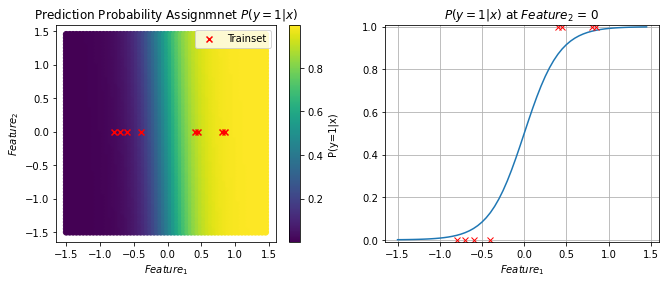

In [4]:
phi_train, phi_test = x_train, x_test
clf_erm = fit_mlp(phi_train, y_train)
erm_probs = clf_erm.predict_proba(phi_test)

w, h = plt.figure().get_size_inches()
fig, axs = plt.subplots(1, 2, figsize=(w * 1.8, h))
ax = axs[0]
im = ax.scatter(phi_test[:, 0], phi_test[:, 1], c=erm_probs[:, 1], cmap="viridis")
ax.scatter(phi_train[:, 0], phi_train[:, 1], marker="x", color="r", label="Trainset")
ax.set_xlabel(r"$Feature_1$")
ax.set_ylabel(r"$Feature_2$")
fig.colorbar(im, label="P(y=1|x)", ax=ax)
ax.legend()
ax.set_title(r"Prediction Probability Assignmnet $P(y=1|x)$")

# 1D plots
indx_on_zero = phi_test[:, 1] == 0.0
ax = axs[1]
ax.plot(phi_test[indx_on_zero, 0], erm_probs[indx_on_zero, 1])
ax.plot(phi_train[:, 0], y_train, "rx", label="Trainset")
ax.set_title(r"$P(y=1|x)$ at $Feature_2$ = 0")
ax.set_ylim(-0.01, 1.01)
ax.set_xlabel(r"$Feature_1$")
ax.grid()
plt.show()

## pNML

In [5]:
# Numerical pNML
regret_numerical = calc_numerical_regres(phi_train, y_train, phi_test)

100%|██████████| 3600/3600 [39:37<00:00,  1.51it/s]  


In [10]:
# Analytical pNML
regret_analytic, x_bot_squares, x_parrallels = [], [], []
x_t_g_list = []
n, m = phi_train.shape
X = phi_train
X_inv = npl.pinv(phi_train)
P_bot = np.eye(m) - X_inv @ X
for phi, probs_i in zip(phi_test, erm_probs):
    # Convert to column vec
    phi = np.expand_dims(phi, 1)
    x_bot = P_bot @ phi
    x_bot_square = float(x_bot.T @ x_bot) ** 2

    x_parallel = float(phi.T @ X_inv @ X_inv.T @ phi)
    if x_bot_square > np.finfo("float").eps:
        x_t_g = phi.T @ x_bot
    else:  # x_bot =0
        x_t_g = x_parallel / (1 + x_parallel)

    p1, p2 = probs_i
    a = (p1 * p2) ** x_t_g
    b1 = p2 * (p1 ** (x_t_g - 1))
    b2 = p1 * (p2 ** (x_t_g - 1))
    nf = 1 + (1 - a) / (1 + a + b1 + b2)

    p1, p2 = probs_i
    nf = p1 / (p1 + p1 ** x_t_g * (1 - p1)) + p2 / (p2 + p2 ** x_t_g * (1 - p2))

    regret_i = float(np.log2(nf))
    regret_analytic.append(regret_i)
    x_bot_squares.append(x_bot_square)
    x_parrallels.append(x_parallel)
    x_t_g_list.append(float(x_t_g))

x_bot_squares = np.asarray(x_bot_squares).squeeze()
x_parrallels = np.asarray(x_parrallels).squeeze()
regret_analytic = np.asarray(regret_analytic).squeeze()
x_t_g_list = np.asarray(x_t_g_list).squeeze()

<ipython-input-11-e4959706317c>:66: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


<Figure size 432x288 with 0 Axes>

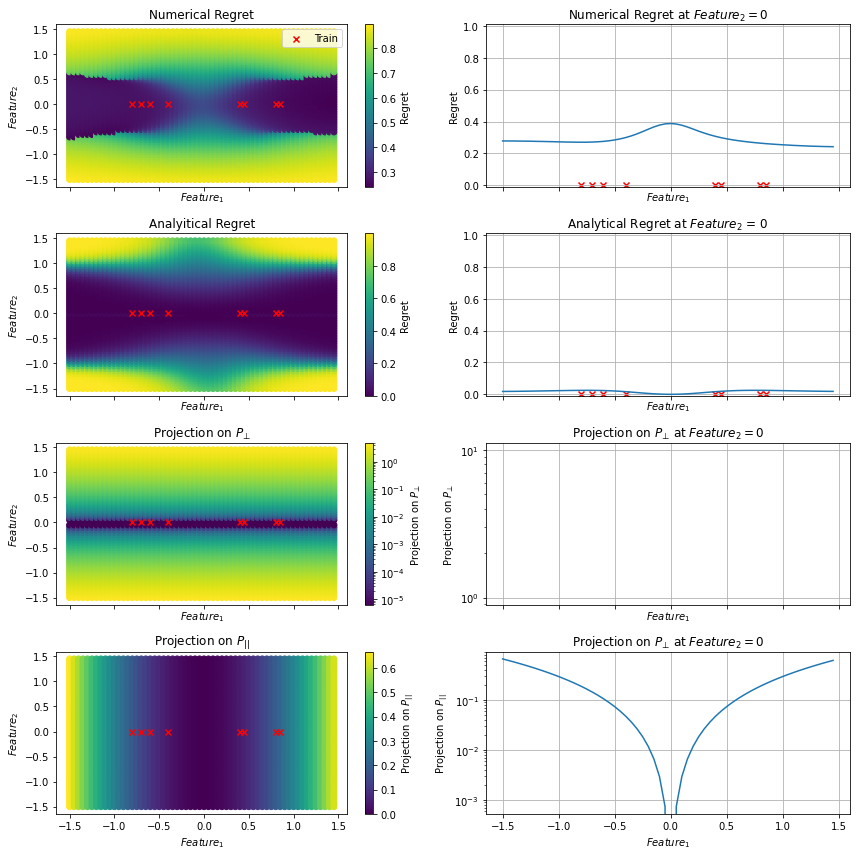

In [11]:
w, h = plt.figure().get_size_inches()
fig, axs = plt.subplots(4, 2, sharex=True, figsize=(w * 2, h * 3))

ax = axs[0, 0]
im = ax.scatter(phi_test[:, 0], phi_test[:, 1], c=regret_numerical, cmap="viridis")
ax.scatter(phi_train[:, 0], phi_train[:, 1], marker="x", color="r", label="Train")
ax.set_xlabel(r"$Feature_1$")
ax.set_ylabel(r"$Feature_2$")
ax.set_title("Numerical Regret")
ax.legend(loc=1)
fig.colorbar(im, label="Regret", ax=ax)

ax = axs[1, 0]
im = ax.scatter(phi_test[:, 0], phi_test[:, 1], c=regret_analytic, cmap="viridis")
ax.scatter(phi_train[:, 0], phi_train[:, 1], marker="x", color="r", label="Train")
ax.set_xlabel(r"$Feature_1$")
ax.set_ylabel(r"$Feature_2$")
ax.set_title("Analyitical Regret")

fig.colorbar(im, label="Regret", ax=ax)

ax = axs[2, 0]
im = ax.scatter(
    phi_test[:, 0], phi_test[:, 1], c=x_bot_squares, cmap="viridis", norm=mpl.colors.LogNorm(),
)
ax.scatter(phi_train[:, 0], phi_train[:, 1], marker="x", color="r", label="Trainset")
ax.set_xlabel(r"$Feature_1$")
ax.set_ylabel(r"$Feature_2$")
fig.colorbar(im, label=r"Projection on $P_\bot$", ax=ax)
ax.set_title(r"Projection on $P_\bot$")

ax = axs[3, 0]
im = ax.scatter(
    phi_test[:, 0], phi_test[:, 1], c=x_parrallels, cmap="viridis",
)
ax.scatter(phi_train[:, 0], phi_train[:, 1], marker="x", color="r", label="Trainset")
ax.set_xlabel(r"$Feature_1$")
ax.set_ylabel(r"$Feature_2$")
fig.colorbar(im, label=r"Projection on $P_{||}$", ax=ax)
ax.set_title(r"Projection on $P_{||}$")


# 1D plots
indx_on_zero = phi_test[:, 1] == 0.0

ax = axs[0, 1]
ax.plot(phi_test[indx_on_zero, 0], regret_numerical[indx_on_zero])
ax.scatter(phi_train[:, 0], [0] * len(phi_train), marker="x", color="r", label="Trainset")
ax.set_ylabel("Regret")
ax.set_xlabel(r"$Feature_1$")
ax.set_title(r"Numerical Regret at $Feature_2=0$")
ax.grid()
ax.set_ylim(-0.01, 1.01)

ax = axs[1, 1]
ax.plot(phi_test[indx_on_zero, 0], regret_analytic[indx_on_zero])
ax.scatter(phi_train[:, 0], [0] * len(phi_train), marker="x", color="r", label="Trainset")
ax.set_ylabel("Regret")
ax.set_xlabel(r"$Feature_1$")
ax.set_title(r"Analytical Regret at $Feature_2$ = 0")
ax.grid()
ax.set_ylim(-0.01, 1.01)

ax = axs[2, 1]
ax.plot(phi_test[indx_on_zero, 0], x_bot_squares[indx_on_zero])
ax.set_yscale("log")
ax.set_ylabel(r"Projection on $P_\bot$")
ax.set_xlabel(r"$Feature_1$")
ax.set_title(r"Projection on $P_\bot$ at $Feature_2=0$")
ax.grid()

ax = axs[3, 1]
ax.plot(phi_test[indx_on_zero, 0], x_parrallels[indx_on_zero])
ax.set_yscale("log")
ax.set_ylabel(r"Projection on $P_{||}$")
ax.set_xlabel(r"$Feature_1$")
ax.set_title(r"Projection on $P_\bot$ at $Feature_2=0$")
ax.grid()


plt.tight_layout()
plt.show()

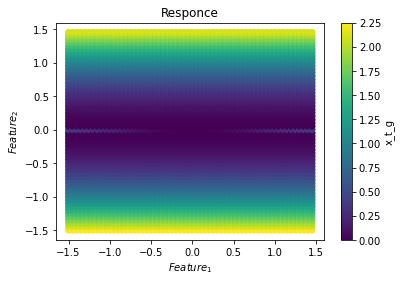

2.1025 2.1025


In [12]:
fig, ax = plt.subplots(1, 1)
im = ax.scatter(phi_test[:, 0], phi_test[:, 1], c=x_t_g_list, cmap="viridis")
ax.set_xlabel(r"$Feature_1$")
ax.set_ylabel(r"$Feature_2$")
ax.set_title("Responce")
fig.colorbar(im, label="x_t_g", ax=ax)
plt.show()
print(x_t_g.max(), x_t_g.min())

In [13]:
x_bot_sqaure

NameError: name 'x_bot_sqaure' is not defined

In [ ]:
x_bot_squares